##1. 사전 준비 작업
1. 코랩에 dataset폴더 만들고 tfrecords파일, labes파일 등을 미리 업로드
2. 드라이브를 마운트함. 그럼 drive란 폴더가 생기며 자신의 Google Drive파일에 접근 가능하게 됨 
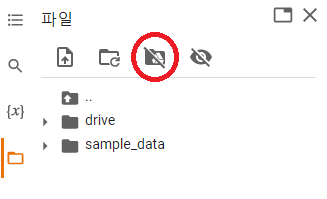

In [178]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random as rn
import os
from collections import Counter
from IPython.display import display, Image

time: 1.7 ms (started: 2022-11-23 17:54:59 +00:00)


In [179]:
import warnings
import logging
logging.getLogger('tensorflow').disabled = True
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

time: 1.18 ms (started: 2022-11-23 17:55:03 +00:00)


In [180]:
!pip install ipython-autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 2.79 s (started: 2022-11-23 17:55:05 +00:00)


In [181]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.85 ms (started: 2022-11-23 17:55:11 +00:00)


In [182]:
# Set seed for reproducibility.

set_seed = 46
np.random.seed(set_seed)
rn.seed(set_seed)
tf.random.set_seed(set_seed)

time: 20.7 ms (started: 2022-11-23 17:55:14 +00:00)


## 2. 사용할 데이터셋의 라벨데이터를 로드 (2번 ~ 5번 안 해도 됨. 학습 성능 향상을 위해 하는 것일 뿐 tfrecord사용법과는 무관)

In [183]:
# Load labels, check headers, check data shape.
label_path = '/content/drive/MyDrive/OpenSourceAI_Team17/dataset/labels/label_6_basic_emo.csv'
label_valid_path = '/content/drive/MyDrive/OpenSourceAI_Team17/dataset/labels/label_6_basic_emo_valid.csv'
label_train_path = '/content/drive/MyDrive/OpenSourceAI_Team17/dataset/labels/label_6_basic_emo_train.csv'
label_test_path = '/content/drive/MyDrive/OpenSourceAI_Team17/dataset/labels/label_6_basic_emo_test.csv'

df_label = pd.read_csv(label_path)
print(df_label.columns)
print(df_label.shape)
print()

LABELS = list(df_label.columns[2:])
# 라벨 종류
print("LABELS=", LABELS)
# 라벨 갯수
print("All class:", len(LABELS))
print()

label_valid = pd.read_csv(label_valid_path)
label_train = pd.read_csv(label_train_path)
label_test = pd.read_csv(label_test_path)

VALID_DATA_SIZE = label_valid.shape[0]
TRAIN_DATA_SIZE = label_train.shape[0]
TEST_DATA_SIZE = label_test.shape[0]

print("TRAIN_DATA_SIZE:", TRAIN_DATA_SIZE)
print("VALID_DATA_SIZE:", VALID_DATA_SIZE)
print("TEST_DATA_SIZE:", TEST_DATA_SIZE)

Index(['img_id', 'clip_id', 'angry', 'disgusted', 'surprised', 'fearful',
       'happy', 'sad'],
      dtype='object')
(12813, 8)

LABELS= ['angry', 'disgusted', 'surprised', 'fearful', 'happy', 'sad']
All class: 6

TRAIN_DATA_SIZE: 10249
VALID_DATA_SIZE: 1282
TEST_DATA_SIZE: 1282
time: 85.9 ms (started: 2022-11-23 17:55:16 +00:00)


## 3. 학습용 데이터(train data)의 각 이미지들에 정답라벨 붙인 딕셔너리 얻기

In [184]:
dict_label_train = {}
for idx, row in label_train.iterrows():
    dict_label_train[row['img_id']] = list(row['angry':'sad'].values)
len(dict_label_train)

10249

time: 4.31 s (started: 2022-11-23 17:55:19 +00:00)


## 4. 만들어둔 학습용 데이터의 라벨 딕셔너리에서 라벨값만 취하기

In [185]:
y_train = list(dict_label_train.values())

time: 1.25 ms (started: 2022-11-23 17:55:27 +00:00)


In [186]:
# 각 라벨들이 가리키는 숫자 추출

# ex) [1, 0, 0, 0] -> 1 = 행복
#     [0, 1, 0, 0] -> 2 = 빡침
#     [0, 0, 1, 0] -> 3 = 기쁨..

y_train_ints = [y.index(1) for y in y_train]
 

time: 14.1 ms (started: 2022-11-23 17:55:29 +00:00)


## 5. 각 감정들(라벨)의 class weight 계산
*class weight: 샘플 수가 상대적으로 적은 Class 쪽에 가중치를 부여하는 방식(클래스 불균형을 해결) - 이 때 클래스라는 건 우리 플젝에선 감정들(결과)을 말함* 

In [187]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(y_train_ints),
                                                  y=y_train_ints)
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.2815040650406504,
 1: 18.3673835125448,
 2: 0.7868109933978198,
 3: 7.6257440476190474,
 4: 11.46420581655481,
 5: 1.106325561312608}

time: 26.1 ms (started: 2022-11-23 17:55:31 +00:00)


In [188]:
n_samples = len(dict_label_train)
n_classes = len(set(y_train_ints))

multiplier = 3
adjusted_cw = class_weights / n_classes * multiplier

log_weights = n_samples / (n_classes * np.log(np.bincount(y_train_ints)))
sum_weights = sum(log_weights)

custom_class_weights = log_weights / sum_weights
custom_class_weights

custom_class_weights += adjusted_cw

class_weight_dict = dict(enumerate(custom_class_weights))

time: 3.32 ms (started: 2022-11-23 17:55:35 +00:00)


## 6. train dataset 정의

In [189]:
BATCH_SIZE = 64

train_data_path = '/content/drive/MyDrive/OpenSourceAI_Team17/dataset/tfrecords/6_basic_emo_train.tfrecords'

def deserialize(serialized_dataset):

    image_feature_description = {
        'label': tf.io.FixedLenFeature([6], tf.int64),  
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }

    target_record = tf.io.parse_single_example(serialized_dataset, image_feature_description)

    image = target_record['image_raw']
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    
    # image = tf.image.resize(image, [64, 64])

    label = target_record['label']
    #label = tf.cast(label, tf.int32)

    return image, label

# tfrecord 데이터셋 불러오기
train_raw_image_dataset = tf.data.TFRecordDataset(train_data_path)

# 불러온 데이터들 각각에 deserialize를 멕임
train_parsed_image_dataset = train_raw_image_dataset.map(deserialize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# 섞음
train_parsed_image_dataset = train_parsed_image_dataset.shuffle(2048)
# 배치
train_parsed_image_dataset = train_parsed_image_dataset.batch(BATCH_SIZE)
# 학습을 빠르게 해주는..뭐 좋은 거라고 함
# train_parsed_image_dataset = train_parsed_image_dataset.prefetch(buffer_size=AUTOTUNE)
# 학습용 데이터는 반복사용 설정을 해줘야 함. 아니면 한 번만 학습하고 종료됨,,--
train_parsed_image_dataset = train_parsed_image_dataset.repeat()

time: 27.9 ms (started: 2022-11-23 17:57:08 +00:00)


(64, 64, 64, 3) (64, 6)


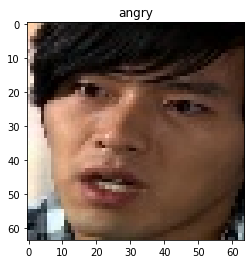

time: 631 ms (started: 2022-11-23 17:57:39 +00:00)


In [197]:
# 이미지랑 라벨 잘 가져와지나 테스트
# batch_x = input(image), batch_y = label(감정)

for batch_x, batch_y in train_parsed_image_dataset:
    # 이미지 하나 = 64 * 64 * 3
    # 라벨 길이 = 6 (6개로 분류하니까)
    # BATCH_SIZE = 64 -> 64개씩 잘랐음
    # 그러므로 batch_x.shape = (64, 64, 64, 3), batch_y.shape = (64, 6)
    print(batch_x.shape, batch_y.shape)

    # 첫 번째 사진이 어떤 감정에 속하는지(0 ~ 5) -> LABELS 리스트에서 인덱싱하면 감정이름을 가져올 수 있음
    # 다만 6_basic_emo_train.tfrecords에 있는 사진들은 angry비율이 압도적으로 높음(5번에서 감정들의 class weight계산 참조)
    target_class = np.argmax(batch_y[0].numpy())
    
    plt.figure()
    
    plt.imshow(batch_x[0].numpy().astype('uint8'))
    plt.title('{}'.format(LABELS[target_class]))
    plt.show()

    break

## 7. valid dataset 정의

In [198]:
valid_data_path = '/content/drive/MyDrive/OpenSourceAI_Team17/dataset/tfrecords/6_basic_emo_valid.tfrecords'

valid_raw_image_dataset = tf.data.TFRecordDataset(valid_data_path)

valid_raw_image_dataset = valid_raw_image_dataset.map(deserialize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_raw_image_dataset = valid_raw_image_dataset.batch(BATCH_SIZE)

time: 21.9 ms (started: 2022-11-23 17:57:44 +00:00)


## 8. 데이터 사용해보기 - CNN 학습시켜보기

In [199]:
initializer = keras.initializers.GlorotUniform(seed=set_seed)
activation =  keras.activations.softmax
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=1e-5,
            decay_steps=TRAIN_DATA_SIZE // BATCH_SIZE * 10,
            decay_rate=0.95)

number_of_classes = 6
        
inputs = keras.Input(shape=(64, 64, 3))
conv1 = keras.layers.Conv2D(128,(3, 3), padding='same', activation='relu')(inputs)
do1 = keras.layers.Dropout(0.5, seed=set_seed)(conv1)         
conv2 = keras.layers.Conv2D(64,(3, 3), padding='same', activation='relu')(do1)
do2 = keras.layers.Dropout(0.5, seed=set_seed)(conv2)         
conv3 = keras.layers.Conv2D(32,(3, 3), padding='same', activation='relu')(do2)
do3 = keras.layers.Dropout(0.5, seed=set_seed)(conv3)       
flatten = keras.layers.Flatten()(do3)    
outputs = keras.layers.Dense(number_of_classes,
                        kernel_initializer=initializer,
                        activation=activation)(flatten) 
clf = keras.Model(inputs, outputs)
        
clf.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 64, 64, 128)       3584      
                                                                 
 dropout_24 (Dropout)        (None, 64, 64, 128)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 64)        73792     
                                                                 
 dropout_25 (Dropout)        (None, 64, 64, 64)        0         
                                                                 
 conv2d_43 (Conv2D)          (None, 64, 64, 32)        18464     
                                                                 
 dropout_26 (Dropout)        (None, 64, 64, 32)        0  

In [200]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,
                                                       restore_best_weights=True)
        
clf.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy'])
        
history = clf.fit(train_parsed_image_dataset, steps_per_epoch=TRAIN_DATA_SIZE // BATCH_SIZE,
                validation_data=valid_raw_image_dataset,
                epochs=100,
                class_weight=class_weight_dict,
                callbacks=[es_callback]) 

Epoch 1/100
160/160 [==============================] - 11s 62ms/step - loss: 25.4124 - accuracy: 0.2280 - val_loss: 14.0510 - val_accuracy: 0.0616
Epoch 2/100
160/160 [==============================] - 10s 66ms/step - loss: 18.0504 - accuracy: 0.2313 - val_loss: 13.1678 - val_accuracy: 0.0367
Epoch 3/100
160/160 [==============================] - 11s 66ms/step - loss: 14.2981 - accuracy: 0.2487 - val_loss: 7.1360 - val_accuracy: 0.0538
Epoch 4/100
160/160 [==============================] - 10s 64ms/step - loss: 11.8359 - accuracy: 0.2565 - val_loss: 4.9004 - val_accuracy: 0.0476
Epoch 5/100
160/160 [==============================] - 11s 68ms/step - loss: 9.5619 - accuracy: 0.2562 - val_loss: 3.9208 - val_accuracy: 0.0343
Epoch 6/100
160/160 [==============================] - 10s 64ms/step - loss: 8.2232 - accuracy: 0.2547 - val_loss: 2.4806 - val_accuracy: 0.0897
Epoch 7/100
160/160 [==============================] - 10s 62ms/step - loss: 6.9386 - accuracy: 0.2537 - val_loss: 2.1719 - 

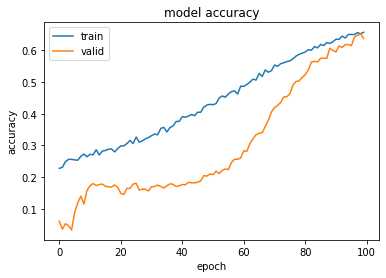

time: 128 ms (started: 2022-11-23 18:19:14 +00:00)


In [203]:
# 정확도 history

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

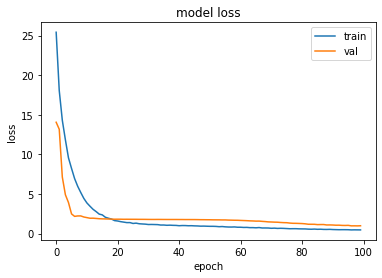

time: 124 ms (started: 2022-11-23 18:19:29 +00:00)


In [204]:
# 손실 history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## 9. test dataset 정의

In [215]:
def deserialize_for_test(serialized_dataset):

    image_feature_description = {
        'label': tf.io.FixedLenFeature([6], tf.int64),  
        'image_raw': tf.io.FixedLenFeature([], tf.string),
    }

    target_record = tf.io.parse_single_example(serialized_dataset, image_feature_description)

    image = target_record['image_raw']
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)

    return image

test_data_path = '/content/drive/MyDrive/OpenSourceAI_Team17/dataset/tfrecords/6_basic_emo_test.tfrecords'

test_raw_image_dataset = tf.data.TFRecordDataset(test_data_path)

test_raw_image_dataset = test_raw_image_dataset.map(deserialize_for_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_raw_image_dataset = test_raw_image_dataset.batch(1)

time: 80.4 ms (started: 2022-11-23 18:30:37 +00:00)


## 10. 모델 테스트

In [216]:
print(test_raw_image_dataset)
loss, acc = clf.evaluate(test_raw_image_dataset, steps=TEST_DATA_SIZE)
print("Test accuracy:", acc)
predictions = clf.predict(test_raw_image_dataset.take(5))
print("A test output from the last layer:", predictions[0])
print("Index of the maximum value:", np.argmax(predictions[0]))
print("Label:", LABELS[np.argmax(predictions[0])])

<BatchDataset element_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name=None)>
1282/1282 [==============================] - 2s 2ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00
Test accuracy: 0.0
5/5 [==============================] - 0s 8ms/step
A test output from the last layer: [0.41283104 0.32094097 0.07896024 0.04749989 0.04690055 0.09286731]
Index of the maximum value: 0
Label: angry
time: 2.88 s (started: 2022-11-23 18:30:39 +00:00)


In [217]:
predictions

array([[4.1283104e-01, 3.2094097e-01, 7.8960240e-02, 4.7499888e-02,
        4.6900552e-02, 9.2867307e-02],
       [3.5738257e-01, 2.0554128e-01, 5.3236485e-02, 6.1174788e-02,
        3.5107143e-02, 2.8755772e-01],
       [2.4969260e-01, 2.3280008e-01, 7.3567294e-02, 2.5780329e-02,
        2.5671044e-01, 1.6144922e-01],
       [8.4123814e-01, 5.3252163e-04, 8.1515901e-02, 1.2421666e-02,
        1.2668310e-02, 5.1623438e-02],
       [9.3597704e-01, 3.9848808e-04, 3.4242116e-02, 1.4042165e-03,
        1.6604738e-05, 2.7961625e-02]], dtype=float32)

time: 11.9 ms (started: 2022-11-23 18:31:38 +00:00)


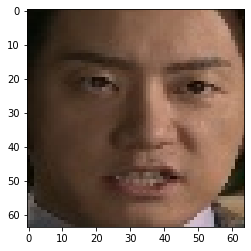

time: 339 ms (started: 2022-11-23 18:38:47 +00:00)


In [229]:
# 테스트했던 이미지 출력

data, = test_parsed_image_dataset.take(1)
plt.imshow(data[0][0])